데이터의 전처리는 모델의 성능에 직접적인 영향을 준다.  
특히 BoW를 기반으로 하는 DTM 이나 TF-IDF 의 경우, 사용하는 **단어의 수** 를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있다.

단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있다.

단어의 수에 따라 모델의 성능이 어떻게 변하는지 테스트해 본다.

### 라이브러리 버전 확인

In [2]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.6.0
3.4.3
0.11.2
1.22.2
1.3.3
1.0


## 1. 데이터 불러오기
사용할 데이터는 로이터 뉴스 데이터이다. 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터이다.   
텐서플로우 데이터셋에서 제공하고 있는 데이터로 쉽게 다운로드 가능

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### (1) 훈련데이터와 테스트 데이터 로드하기
총 세 가지 경우의 단어 개수를 가지고 실험한다.
1) 모든 단어 사용  
2) 빈도수 상위 5,000개의 단어만 사용  
3) 직접 단어 개수 설정해서 사용

# 1) 모든 단어 사용

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [4]:
# 데이터 구성 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [5]:
# 클래스 개수 
num_classes = max(y_train) + 1
print('클래스의 수: {}'.format(num_classes))

클래스의 수: 46


### (2) 데이터 분포 확인

훈련용 뉴스의 최대 길이 : 2376
훈련용 뉴스의 평균 길이 : 145.5398574927633


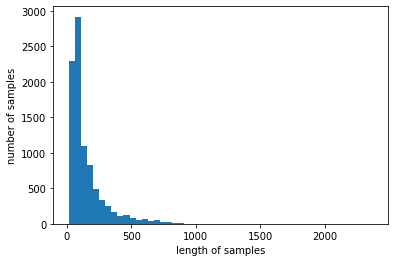

In [6]:
print('훈련용 뉴스의 최대 길이 : {}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 : {}'.format(sum(map(len, x_train))/len(x_train)))
      
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

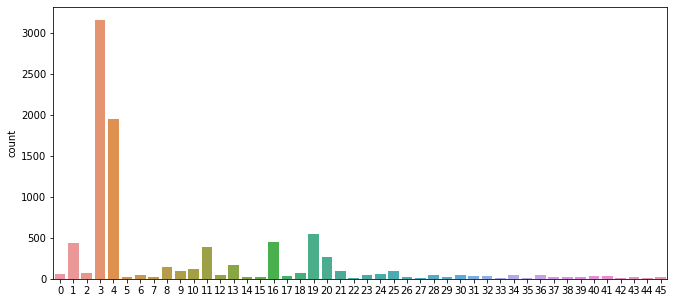

In [7]:
# 클래스 별로 확인
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(11, 5)
sns.countplot(x=y_train)
plt.show()

3번, 4번 클래스가 대부분을 차지하고 있음 

## 2. 데이터 복원하기
### 원본 뉴스 데이터로 복원
이 데이터는 이미 어느 정도 전처리가 되어 각 단어가 정수 시퀀스로 변환된 채 제공되지만, 이를 텍스트로 다시 돌려 벡터화를 시킨다. 

아래와 같이 로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공한다. 이를 word_index로 저장해보자.

In [8]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

In [9]:
word_index['the']

1

뉴스 데이터 안에서 단어 'the'는 사실 1번이 아니라 4번 단어이다. 

0번, 1번, 2번은 사실 각각 <pad\>, <sos\>, <unk\>라는 자연어 처리를 위한 특별한 토큰들을 위해 맵핑된 번호이기 때문에 word_index에서 index_word를 만들 때, 각 정수에 +3을 해준다.

In [10]:
index_to_word = {index+3 : word for word, index in word_index.items()}

In [11]:
print(index_to_word[4])

the


In [12]:
# index_to_word 에 숫자 0은 <pad>, 1은 <sos>, 2는 <unk>
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index] = token

In [13]:
print(index_to_word[1])

<sos>


In [18]:
# 첫번째 훈련용 뉴스 기사를 원래 텍스트로 복원해본다.
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [19]:
# 전체 훈련용 뉴스 데이터와 테스트용 뉴스 데이터를 텍스트 데이터로 변환
# 훈련용 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

# 테스트용 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
    
x_test = decoded
print(len(x_test))

8982
2246


## 3. 벡터화하기

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### (1) DTM 생성

In [21]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


26506개의 단어가 사용됨을 알 수 있다.

### (2) TF-IDF Matrix 생성

In [22]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 4. 모델 적용하기
>**사용할 모델**  
나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅

In [23]:
# 라이브러리 불러오기
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브베이즈
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score # 정확도 계산

### (1) 모델 생성 및 학습

In [25]:
# 모델 생성
nb = MultinomialNB()
cnb = ComplementNB()
lr = LogisticRegression(C = 10000, penalty='l2', max_iter=10000)
lsvc = LinearSVC(C = 1000, penalty = 'l1', max_iter = 10000, dual=False)
tree = DecisionTreeClassifier(max_depth = 10, random_state=0)
forest = RandomForestClassifier(n_estimators = 5, random_state=0)
gb = GradientBoostingClassifier(random_state=0, verbose=3)
voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10000, penalty='l2')),
    ('cnb', ComplementNB()),
    ('gb', GradientBoostingClassifier(random_state=0)),
], voting='soft', n_jobs=-1)

# 학습
nb.fit(tfidfv, y_train)
cnb.fit(tfidfv, y_train)
lr.fit(tfidfv, y_train)
lsvc.fit(tfidfv, y_train)
tree.fit(tfidfv, y_train)
forest.fit(tfidfv, y_train)
gb.fit(tfidfv, y_train)
voting.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.4301           19.45m
         2       76760.8864           19.24m
         3   766490025.2967           19.00m
         4 660857139232122368.0000           18.75m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           18.60m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           18.46m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           18.24m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           18.03m
         9 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cnb', ComplementNB()),
                             ('gb',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

### (2) 테스트 데이터 변환
훈련 데이터와 동일한 전처리를 수행하여 정확도를 측정한다.

In [26]:
# 테스트 데이터를 DTM 으로 변환
x_test_dtm = dtmvector.transform(x_test)

# DTM을 tfidf로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

### (3) 예측 및 정확도 측정

In [27]:
# 예측값
nb_pred = nb.predict(tfidfv_test)
cnb_pred = cnb.predict(tfidfv_test)
lr_pred = lr.predict(tfidfv_test)
lsvc_pred = lsvc.predict(tfidfv_test)
tree_pred = tree.predict(tfidfv_test)
forest_pred = forest.predict(tfidfv_test)
gb_pred = gb.predict(tfidfv_test)
voting_pred = voting.predict(tfidfv_test)

# 정확도 측정
print('MultinomialNB acc: {:.5f}'.format(accuracy_score(y_test, nb_pred)))
print('ComplementNB  acc: {:.5f}'.format(accuracy_score(y_test, cnb_pred)))
print('LogisticRegression acc: {:.5f}'.format(accuracy_score(y_test, lr_pred)))
print('    SVM      acc: {:.5f}'.format(accuracy_score(y_test, lsvc_pred)))
print('DecisionTree acc: {:.5f}'.format(accuracy_score(y_test, tree_pred)))
print('RandomForest acc: {:.5f}'.format(accuracy_score(y_test, forest_pred)))
print('GradientBoosting acc: {:.5f}'.format(accuracy_score(y_test, gb_pred)))
print('   Voting    acc: {:.5f}'.format(accuracy_score(y_test, voting_pred)))

MultinomialNB acc: 0.59973
ComplementNB  acc: 0.76492
LogisticRegression acc: 0.81745
    SVM      acc: 0.78718
DecisionTree acc: 0.62110
RandomForest acc: 0.65450
GradientBoosting acc: 0.77026
   Voting    acc: 0.81879


전체 단어 수를 이용해 문서를 분류한 결과,  
voting > Logistic > SVM > GradientBoosting > ComplementNB 순으로 정확도가 높았다.    
아무래도 순위권에 있는 logistic, gradientboosting, complementNB 가 voting에서 앙상블로 쓰이다 보니 voting의 성능이 가장 높게 나온 것 같다.  
ComplementNB의 경우 MultinomialNB와 비교했을 때 성능 차이가 많이 나는데, 아무래도 뉴스데이터의 label 불균형 때문에 불균형한 경우에 대비한 ComplementNB가 훨씬 좋은 성능을 보인 것 같다.

# 2) 빈도수 상위 5,000개의 단어만 사용
### 1 데이터 불러오기

In [54]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

### 2 데이터 복원하기

In [55]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

index_to_word = {index+3 : word for word, index in word_index.items()}
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index] = token
    
# 전체 훈련용 뉴스 데이터와 테스트용 뉴스 데이터를 텍스트 데이터로 변환
# 훈련용 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

# 테스트용 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
    
x_test = decoded
print(len(x_test))

8982
2246


### 3 벡터화

In [56]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print('DTM shape',x_train_dtm.shape)

# TF-IDF Matrix
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print('TFIDF', tfidfv.shape)

DTM shape (8982, 4867)
TFIDF (8982, 4867)


### 4 모델 적용 및 평가

In [57]:
# 모델 생성
'''
nb = MultinomialNB()
cnb = ComplementNB()
lr = LogisticRegression(C = 10000, penalty='l2', max_iter=10000)
lsvc = LinearSVC(C = 1000, penalty = 'l1', max_iter = 10000, dual=False)
tree = DecisionTreeClassifier(max_depth = 10, random_state=0)
forest = RandomForestClassifier(n_estimators = 5, random_state=0)
gb = GradientBoostingClassifier(random_state=0)#, verbose=3)
voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10000, penalty='l2')),
    ('cnb', ComplementNB()),
    ('gb', GradientBoostingClassifier(random_state=0)),
], voting='soft', n_jobs=-1)
'''
# 학습
nb.fit(tfidfv, y_train)
cnb.fit(tfidfv, y_train)
lr.fit(tfidfv, y_train)
lsvc.fit(tfidfv, y_train)
tree.fit(tfidfv, y_train)
forest.fit(tfidfv, y_train)
gb.fit(tfidfv, y_train)
voting.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.4697           16.74m
         2     2131099.0239           16.82m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           16.74m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           16.60m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           16.44m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           16.29m
         7 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           16.11m
         8 44306729953030165998037436352594999562969554969155989028586935092359272354521328055415871220420274508866530693

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cnb', ComplementNB()),
                             ('gb',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [58]:
# 테스트 데이터를 DTM 으로 변환
x_test_dtm = dtmvector.transform(x_test)

# DTM을 tfidf로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

In [59]:
# 예측값
nb_pred = nb.predict(tfidfv_test)
cnb_pred = cnb.predict(tfidfv_test)
lr_pred = lr.predict(tfidfv_test)
lsvc_pred = lsvc.predict(tfidfv_test)
tree_pred = tree.predict(tfidfv_test)
forest_pred = forest.predict(tfidfv_test)
gb_pred = gb.predict(tfidfv_test)
voting_pred = voting.predict(tfidfv_test)

# 정확도 측정
print('빈도 수 상위 5,000개 단어')
print('MultinomialNB acc: {:.5f}'.format(accuracy_score(y_test, nb_pred)))
print('ComplementNB  acc: {:.5f}'.format(accuracy_score(y_test, cnb_pred)))
print('LogisticRegression acc: {:.5f}'.format(accuracy_score(y_test, lr_pred)))
print('    SVM      acc: {:.5f}'.format(accuracy_score(y_test, lsvc_pred)))
print('DecisionTree acc: {:.5f}'.format(accuracy_score(y_test, tree_pred)))
print('RandomForest acc: {:.5f}'.format(accuracy_score(y_test, forest_pred)))
print('GradientBoosting acc: {:.5f}'.format(accuracy_score(y_test, gb_pred)))
print('   Voting    acc: {:.5f}'.format(accuracy_score(y_test, voting_pred)))

빈도 수 상위 5,000개 단어
MultinomialNB acc: 0.67320
ComplementNB  acc: 0.77070
LogisticRegression acc: 0.80276
    SVM      acc: 0.76803
DecisionTree acc: 0.61799
RandomForest acc: 0.70125
GradientBoosting acc: 0.76759
   Voting    acc: 0.81612


빈도수 상위 5,000개 단어에 대해 문서를 분류해보았다.  
Voting > Logistic > Complement > SVM > GradientBoosting 순으로 높은 정확도를 보인다.  
전체 단어를 사용한 경우와 비교했을 때, voting은 역시나 가장 높은 성능을 보였고, ComplementNB가 svm이나 부스팅보다 높은 정확도를 보였다. (차이는 0.01 정도로 큰 차이는 아니다.)

정확도뿐만 아니라 조화평균(f1_score)은 어떻게 나는지 살펴보자.

In [60]:
# f1 score 측정
from sklearn.metrics import f1_score

# f1_score(y_true, y_pred, average=['weighted'])
#average=[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택]

print('MultinomialNB f1_score: {:.5f}'.format(f1_score(y_test, nb_pred, average='weighted')))
print('ComplementNB f1_score: {:.5f}'.format(f1_score(y_test, cnb_pred, average='weighted')))
print('Logistic Regression f1: {:.5f}'.format(f1_score(y_test, lr_pred, average='weighted')))
print('    SVM     f1_score: {:.5f}'.format(f1_score(y_test, lsvc_pred, average='weighted')))
print('DecisionTree f1_score: {:.5f}'.format(f1_score(y_test, tree_pred, average='weighted')))
print('RandomForest f1_score: {:.5f}'.format(f1_score(y_test, forest_pred, average='weighted')))
print('GradientBoosting f1_score: {:.5f}'.format(f1_score(y_test, gb_pred, average='weighted')))
print('   Voting    f1_score: {:.5f}'.format(f1_score(y_test, voting_pred, average='weighted')))

MultinomialNB f1_score: 0.60125
ComplementNB f1_score: 0.74590
Logistic Regression f1: 0.79735
    SVM     f1_score: 0.76530
DecisionTree f1_score: 0.57300
RandomForest f1_score: 0.67702
GradientBoosting f1_score: 0.76625
   Voting    f1_score: 0.81267


f1_score는 
Voting > Logistic > Gradientboosting > svm > ComplementNB 순이다.  
정확도 순위와는 차이가 있지만 그럼에도 Voting과 Logistic Regression은 높은 수치를 보인다. 

DecisionTree는 정확도나 f1_score나 가장 낮은 성능을 보이는데, 아마 훈련데이터에 대한 과적합때문이 아닐까.

# 3) 직접 단어 개수 설정 : 1000개
5000, 10000, 20000  

### 1 모델 불러오기

In [36]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

### 2 데이터 복원하기

In [37]:
word_index = reuters.get_word_index(path='reuters_word_index.json')

index_to_word = {index+3 : word for word, index in word_index.items()}
for index, token in enumerate(('<pad>','<sos>','<unk>')):
    index_to_word[index] = token
    
# 전체 훈련용 뉴스 데이터와 테스트용 뉴스 데이터를 텍스트 데이터로 변환
# 훈련용 데이터
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

# 테스트용 데이터
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
    
x_test = decoded
print(len(x_test))

8982
2246


### 3 벡터화

In [38]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print('DTM shape',x_train_dtm.shape)

# TF-IDF Matrix
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print('TFIDF', tfidfv.shape)

DTM shape (8982, 969)
TFIDF (8982, 969)


### 4 모델 적용 및 평가
#### 학습

In [39]:
nb.fit(tfidfv, y_train)

MultinomialNB()

In [40]:
cnb.fit(tfidfv, y_train)

ComplementNB()

In [41]:
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=10000)

In [42]:
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=10000, penalty='l1')

In [43]:
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [44]:
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [45]:
gb.fit(tfidfv, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.5717           13.58m
         2        3967.8426           13.58m
         3        4754.6181           13.50m
         4     1016060.1416           13.37m
         5     1016079.3289           13.26m
         6     6974797.9520           13.13m
         7     6974845.8927           12.99m
         8     6974845.8761           12.85m
         9 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           12.71m
        10 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           12.57m
        11 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           12.44m
        12 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           12.30m
        13 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           1

GradientBoostingClassifier(random_state=0, verbose=3)

In [46]:
voting.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cnb', ComplementNB()),
                             ('gb',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [47]:
# 테스트 데이터를 DTM 으로 변환
x_test_dtm = dtmvector.transform(x_test)

# DTM을 tfidf로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

In [48]:
# 예측값
nb_pred = nb.predict(tfidfv_test)
cnb_pred = cnb.predict(tfidfv_test)
lr_pred = lr.predict(tfidfv_test)
lsvc_pred = lsvc.predict(tfidfv_test)
tree_pred = tree.predict(tfidfv_test)
forest_pred = forest.predict(tfidfv_test)
gb_pred = gb.predict(tfidfv_test)
voting_pred = voting.predict(tfidfv_test)

# 정확도 측정
print('빈도 수 상위 1,000개 단어')
print('MultinomialNB acc: {:.5f}'.format(accuracy_score(y_test, nb_pred)))
print('ComplementNB  acc: {:.5f}'.format(accuracy_score(y_test, cnb_pred)))
print('LogisticRegression acc: {:.5f}'.format(accuracy_score(y_test, lr_pred)))
print('    SVM      acc: {:.5f}'.format(accuracy_score(y_test, lsvc_pred)))
print('DecisionTree acc: {:.5f}'.format(accuracy_score(y_test, tree_pred)))
print('RandomForest acc: {:.5f}'.format(accuracy_score(y_test, forest_pred)))
print('GradientBoosting acc: {:.5f}'.format(accuracy_score(y_test, gb_pred)))
print('   Voting    acc: {:.5f}'.format(accuracy_score(y_test, voting_pred)))

빈도 수 상위 1,000개 단어
MultinomialNB acc: 0.68566
ComplementNB  acc: 0.73464
LogisticRegression acc: 0.73865
    SVM      acc: 0.72262
DecisionTree acc: 0.61799
RandomForest acc: 0.70748
GradientBoosting acc: 0.74533
   Voting    acc: 0.78406


빈도수 상위 5000보다 좋은 결과면 500도 해보려고 했지만 안 해도 될 것 같다. 

MultinomialNB의 경우 0.01 정도의 성능향상이 있었지만 나머지 모델에서 이보다 큰 성능 저하가 있다.  
역시나 voting의 성능이 가장 높다.

루브릭에서 분류 모델의 f1 score가 기준 이상 높게 나왔냐는 질문을 이 모델들을 돌리고 나서야 보게 되어 이번 단어 개수에 대한 성능이 높게 나오길 바랬는데 아쉽게 되었다. 

모델들 돌리는 데 생각보다 많은 시간이 걸린다.. max_iter 때문에 그런 것 같다. gradient boosting도 정말 오래 걸린다. + voting까지

모델 변수 이름을 다 다르게 지정했으면 모델을 다시 돌리지 않고도 f1 score를 측정할 수 있었을텐데.. 앞으로는 변수 명을 꼭 다르게 지정해서 혹시 모를 상황에 대비해야겠다. 

In [53]:
# f1 score 측정
from sklearn.metrics import f1_score

# f1_score(y_true, y_pred, average=['weighted'])
#average=[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택]

print('MultinomialNB f1_score: {:.5f}'.format(f1_score(y_test, nb_pred, average='weighted')))
print('ComplementNB f1_score: {:.5f}'.format(f1_score(y_test, cnb_pred, average='weighted')))
print('Logistic Regression f1: {:.5f}'.format(f1_score(y_test, lr_pred, average='weighted')))
print('    SVM     f1_score: {:.5f}'.format(f1_score(y_test, lsvc_pred, average='weighted')))
print('DecisionTree f1_score: {:.5f}'.format(f1_score(y_test, tree_pred, average='weighted')))
print('RandomForest f1_score: {:.5f}'.format(f1_score(y_test, forest_pred, average='weighted')))
print('GradientBoosting f1_score: {:.5f}'.format(f1_score(y_test, gb_pred, average='weighted')))
print('   Voting    f1_score: {:.5f}'.format(f1_score(y_test, voting_pred, average='weighted')))

MultinomialNB f1_score: 0.63650
ComplementNB f1_score: 0.69730
Logistic Regression f1: 0.73243
    SVM     f1_score: 0.71978
DecisionTree f1_score: 0.54526
RandomForest f1_score: 0.68285
GradientBoosting f1_score: 0.73848
   Voting    f1_score: 0.77702


f1 score의 average 를 'weighted'로 주어 label의 불균형을 고려하였다.  
voting의 정확도가 가장 높았는데, f1_score 또한 가장 높은 수치를 보이는 것으로 보아 성능이 가장 좋다고 볼 수 있을 것 같다. 

f1 score가 단어사전 개수에도 영향을 받는지 확인하기 위해  
위에서 가장 성능이 좋았던 5000개 단어사전으로 학습된 모델을 다시 돌려본다.
***
확실히 성능에 차이가 있었다. 5000개 단어사전을 적용한 모델에서는 Voting의 f1_score가 81%로 다른 단어사전에 비해 꽤 높게 나왔다. 

단어사전의 개수를 총 네 가지로 분류하여 실험해보았다.  
1) 전체 단어  
2) 10,000 개 단어  
3) 5,000 개 단어  
4) 1,000 개 단어  

전반적으로 성능이 가장 좋았던 단어 개수는 5,000개였다.  
빈도수 상위 5,000개 단어사전이 정확도와 f1_score 모두 높았다.

# 4) 딥러닝 모델과 비교해보기
빈도수 상위 5,000개 단어사전을 가지고 데이터를 딥러닝 모델에 넣어본다.  
모델은 RNN을 사용한다.

### 1 데이터 불러오기

In [4]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


### 2 데이터 보정 및 복원

In [5]:
# 데이터 보정 및 복원
word_index = reuters.get_word_index(path='reuters_word_index.json')

index_to_word = {index : word for word, index in word_index.items()}

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_index = {k:(v+3) for k, v in word_index.items()}

#처음 몇 개 인덱스는 사전에 정의되어 있다.
word_index["<pad>"] = 0
word_index["<sos>"] = 1
word_index["<unk>"] = 2 
word_index["<unused>"] = 3

index_to_word = {index: word for word,index in word_index.items()}


565248/550378 [==============================] - 0s 0us/step


"    \n# 전체 훈련용 뉴스 데이터와 테스트용 뉴스 데이터를 텍스트 데이터로 변환\n# 훈련용 데이터\ndecoded = []\nfor i in range(len(x_train)):\n    t = ' '.join([index_to_word[index] for index in x_train[i]])\n    decoded.append(t)\n    \nx_train = decoded\nprint(len(x_train))\n\n# 테스트용 데이터\ndecoded = []\nfor i in range(len(x_test)):\n    t = ' '.join([index_to_word[index] for index in x_test[i]])\n    decoded.append(t)\n    \nx_test = decoded\nprint(len(x_test))\n"

In [6]:
print(word_index['<sos>'])
print(word_index['<pad>'])
print(word_index['the'])
print(index_to_word[4])

1
0
4
the


### 3 문장의 maxlen 설정

In [7]:
# 텍스트데이터 문장길이의 리스트를 생성한다
total_data_text = list(x_train) + list(x_test)

#문장길이의 평균값, 최대값, 표준편차 계산해본다
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장 길이 평균: ', np.mean(num_tokens))
print('문장 길이 최대: ', np.max(num_tokens))
print('문장 길이 표준편차: ', np.std(num_tokens))

# 예를 들어, 최대길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)

print('pad_sequences maxlen: ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장 길이 평균:  145.96419665122906
문장 길이 최대:  2376
문장 길이 표준편차:  145.8784764459447
pad_sequences maxlen:  437
전체 문장의 0.9438902743142145%가 maxlen 설정값 이내에 포함됩니다.


In [8]:
#list(x_train)

### 4 데이터에 pad_sequences 적용

In [9]:
import tensorflow as tf

In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, 
                                                      value=word_index['<pad>'],
                                                      padding='post', #또는 'pre'
                                                      maxlen = max_len)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value=word_index['<pad>'],
                                                     padding = 'post', #또는 'pre'
                                                     maxlen = max_len)

print(x_train.shape)

(8982, 437)


https://stackoverflow.com/questions/46323296/keras-pad-sequences-throwing-invalid-literal-for-int-with-base-10

keras 모델에는 string을 쓰면 안된다.

In [11]:
from tensorflow.keras.utils import to_categorical ## 추가

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### 5 딥러닝 모델 설계와 훈련

In [12]:
vocab_size = 5000 # 단어사전 크기
word_vector_dim = 128 # 워드벡터의 차원 수
hidden_units = 128 ## 추가

# 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim)) ## 수정
model.add(tf.keras.layers.LSTM(hidden_units)) ## 수정
model.add(tf.keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 777,518
Trainable params: 777,518
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 모델 학습
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

epochs = 20

history = model.fit(x_train, 
                   y_train,
                   epochs = epochs,
                   batch_size = 128,
                   verbose=1)

Epoch 1/20
71/71 [==============================] - 125s 2s/step - loss: 2.5986 - accuracy: 0.3451
Epoch 2/20
71/71 [==============================] - 124s 2s/step - loss: 2.4021 - accuracy: 0.3529
Epoch 3/20
71/71 [==============================] - 123s 2s/step - loss: 2.3972 - accuracy: 0.3550
Epoch 4/20
71/71 [==============================] - 122s 2s/step - loss: 2.3959 - accuracy: 0.3550
Epoch 5/20
71/71 [==============================] - 123s 2s/step - loss: 2.3967 - accuracy: 0.3549
Epoch 6/20
71/71 [==============================] - 122s 2s/step - loss: 2.3932 - accuracy: 0.3548
Epoch 7/20
71/71 [==============================] - 123s 2s/step - loss: 2.3897 - accuracy: 0.3569
Epoch 8/20
71/71 [==============================] - 123s 2s/step - loss: 2.3820 - accuracy: 0.3595
Epoch 9/20
71/71 [==============================] - 124s 2s/step - loss: 2.3718 - accuracy: 0.3622
Epoch 10/20
71/71 [==============================] - 124s 2s/step - loss: 2.3618 - accuracy: 0.3651
Epoch 11/

### 6 모델 평가

In [16]:
results = model.evaluate(x_test, y_test)
print(results)

71/71 [==============================] - 17s 243ms/step - loss: 2.4373 - accuracy: 0.3722
[2.437252998352051, 0.3722172677516937]


정확도가 약 37%이다.  
아무래도 딥러닝 모델에 쓰기에는 데이터가 적은데다가 라벨도 불균형해서 모델이 학습하기 쉽지 않았을 것 같다.  

결국 가장 좋은 성능을 보인 모델은 5000개 단어사전을 사용했을 때, 정확도 81.6%, f1_score 81.2를 보인 머신러닝의 Voting이었다.  
5000개 단어사전을 사용했을 때, 대체적으로 높은 수치가 나온 모델은 voting, logistic, svm, complement, gradient boosting 이었는데, 특히 Voting에서 정확도와 f1_score 모두 높았다.   
Voting은 앙상블 기법으로, 여러 모델의 결과물을 통해 최종값을 도출해 내는데, 이 때 쓰인 모델은 logistic, complementNB, gradient boosting 이다. 소프트맥스함수와 조건부 확률, 앙상블 기법의 결과물들을 모두 참고하다보니 높은 성능이 나오지 않았나 싶다.